In [3]:
# ## 1. Environment Setup and Data Loading

# 🧩 Install all required libraries
!pip install --upgrade pip
!pip install librosa numpy scipy matplotlib soundfile noisereduce
!pip install pyannote.audio==2.1.1  # (optional, for advanced Voice Activity Detection)



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 24.4 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of pyannote-audio to determine which version is compatible with other requirements. This could take a while.
ERROR: Ignored the following versions that require a different python version: 0.5.0 Requires-Python >=3.6,<3.9; 0.5.1 Requires-Python >=3.6,<3.9; 0.6.0 Requires-Python >=3.6,<3.9; 0.7.0 Requires-Python >=3.6,<3.9; 0.8.0 Requires-Python >=3.6,<3.9; 0.9.0 Requires-Python >=3.6,<3.9
ERROR: Could not find a version that satisfies the requirement torchaudio<1.0,>=0.10 (from pyannote-audio) (from versions: 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.

In [ ]:


import os
import numpy as np
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio, display

import noisereduce as nr

import subprocess

INPUT_FILE = "input.webm"  # or .mp3 / .m4a etc.
WAV_FILE = "input.wav"

if not INPUT_FILE.lower().endswith(".wav"):
    print(f"Converting {INPUT_FILE} → {WAV_FILE} ...")
    subprocess.run([
        "ffmpeg", "-i", INPUT_FILE,
        "-ac", "1",              
        "-ar", "44100",          
        WAV_FILE,
        "-y"                     
    ], check=True)
    print("Conversion complete.")
else:
    WAV_FILE = INPUT_FILE


if not os.path.exists(INPUT_FILE):
    raise FileNotFoundError(f"Expected {INPUT_FILE} in working directory. Please add a sample audio file named '{INPUT_FILE}'.")

# Load with sr=None to preserve original sampling rate and channels
y, sr = librosa.load(INPUT_FILE, sr=None, mono=True)  # force mono for pipeline simplicity
print(f"Loaded '{INPUT_FILE}': sample rate = {sr} Hz, audio shape = {y.shape}, duration = {len(y)/sr:.2f} sec")


Converting input.webm → input.wav ...
Conversion complete.


/tmp/ipython-input-4128751199.py:51: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(INPUT_FILE, sr=None, mono=True)  # force mono for pipeline simplicity
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Loaded 'input.webm': sample rate = 48000 Hz, audio shape = (708480,), duration = 14.76 sec


### 2. Voice Activity Detection (VAD) & Segmentation

VAD removes long silences and non-speech regions, which:
- Reduces the size of data to store and process.
- Improves downstream transcription and model training quality.
- Helps to derive a clean speech-only corpus.

We attempt to use `pyannote.audio` VAD (pretrained pipeline). If `pyannote` is not available/configured, we fall back to an energy-based segmentation method using `librosa.effects.split`.

The output of this step is an array `y_vad` containing concatenated speech-only segments.


In [ ]:
# 2. Voice Activity Detection (VAD) & Segmentation (Code)

def vad_with_pyannote(input_path):
    """
    Use pyannote.audio Pipeline to get speech segments (requires HF token).
    Returns list of (start_s, end_s) speech segments in seconds.
    """
    # If you haven't set the HF token, set it in environment:
    pipeline = Pipeline.from_pretrained("pyannote/voice-activity-detection")
    # pipeline expects an audio file path
    diarization = pipeline({"audio": input_path})
    segments = []
    for turn, _, _ in diarization.itertracks(yield_label=True):
        start = turn.start
        end = turn.end
        segments.append((start, end))
    return segments

def vad_with_librosa(y, sr, top_db=40, min_segment_duration=0.3):
    """
    Fallback VAD using librosa.effects.split (energy-based).
    top_db: threshold (lower => more sensitive)
    min_segment_duration: seconds threshold to filter out very short segments
    Returns list of (start_s, end_s)
    """
    # Split returns sample index ranges where energy > threshold
    intervals = librosa.effects.split(y, top_db=top_db)
    segments = []
    for start_i, end_i in intervals:
        duration = (end_i - start_i) / sr
        if duration >= min_segment_duration:
            segments.append((start_i / sr, end_i / sr))
    return segments

# Try pyannote if available, else fallback
if PYANNOTE_AVAILABLE:
    try:
        segments = vad_with_pyannote(INPUT_FILE)
        if not segments:
            print("pyannote returned no segments, falling back to librosa VAD.")
            segments = vad_with_librosa(y, sr)
        else:
            print(f"pyannote detected {len(segments)} segments.")
    except Exception as e:
        print("Error running pyannote pipeline:", e)
        print("Falling back to librosa-based VAD.")
        segments = vad_with_librosa(y, sr)
else:
    segments = vad_with_librosa(y, sr)

print("Detected speech segments (seconds):", segments)

# Concatenate speech segments into y_vad
y_vad = np.array([], dtype=y.dtype)
for (s, e) in segments:
    start_idx = int(round(s * sr))
    end_idx = int(round(e * sr))
    y_vad = np.concatenate((y_vad, y[start_idx:end_idx]))

print(f"Concatenated speech-only audio length = {len(y_vad)} samples ({len(y_vad)/sr:.2f} sec)")


Detected speech segments (seconds): [(np.float64(4.277333333333333), np.float64(4.682666666666667)), (np.float64(5.685333333333333), np.float64(6.026666666666666)), (np.float64(6.506666666666667), np.float64(7.456)), (np.float64(7.744), np.float64(8.064)), (np.float64(8.192), np.float64(9.173333333333334)), (np.float64(9.781333333333333), np.float64(10.154666666666667)), (np.float64(10.581333333333333), np.float64(11.370666666666667)), (np.float64(11.946666666666667), np.float64(12.448)), (np.float64(13.098666666666666), np.float64(13.621333333333334))]
Concatenated speech-only audio length = 248832 samples (5.18 sec)


### 3. Noise Reduction (Spectral Gating)

Noise reduction improves the signal-to-noise ratio (SNR) and makes speech clearer for transcription and model training.

We use spectral gating provided by the `noisereduce` library. To build a noise profile:
- If the raw file contains a short silent region at the start, we can use the first 0.5s as a noise profile.
- Otherwise, we estimate noise from a low-energy portion. Here, we attempt to use the first 0.5 seconds of the original raw audio as the noise sample; if too short, we'll fall back to estimating noise from the lowest-energy regions.


In [ ]:

def get_noise_profile(y, sr, duration=0.5):
    """Return a noise profile of `duration` seconds from the start of y if possible,
       otherwise estimate from lowest-energy slice."""
    n_samples = int(duration * sr)
    if len(y) >= n_samples:
        noise = y[:n_samples]
        return noise
    else:
        # fallback: find a low-energy window
        energy = librosa.feature.rms(y=y)[0]
        # find the frame with minimum energy, map to sample indexes
        min_frame = np.argmin(energy)
        hop_length = 512
        start = max(0, min_frame * hop_length - n_samples // 2)
        end = min(len(y), start + n_samples)
        return y[start:end]

# Choose a noise sample from original raw audio (not VAD-trimmed) for better noise capture
noise_sample = get_noise_profile(y, sr, duration=0.5)
print(f"Noise sample length: {len(noise_sample)} samples ({len(noise_sample)/sr:.3f} s)")

# Apply noisereduce spectral gating
# If y_vad is empty (no speech detected), fallback to the original signal to avoid errors
if y_vad.size == 0:
    print("Warning: No speech detected after VAD; applying noise reduction on the original file.")
    target_for_denoise = y
    sr_target = sr
else:
    target_for_denoise = y_vad
    sr_target = sr

# noisereduce expects float arrays
y_denoised = nr.reduce_noise(y=target_for_denoise, y_noise=noise_sample, sr=sr_target, prop_decrease=1.0)
print(f"Denoised audio length: {len(y_denoised)} samples ({len(y_denoised)/sr_target:.2f} sec)")


Noise sample length: 24000 samples (0.500 s)
Denoised audio length: 248832 samples (5.18 sec)


###4. Amplitude Normalization (Peak)

Normalization ensures consistent loudness across your dataset. We perform peak normalization so that the maximum absolute amplitude scales to a safe peak (e.g., 0.95), preventing clipping and keeping dynamic range for later processing.


In [ ]:
scaling_target = 0.95

# librosa.util.normalize with norm=np.inf scales so max(abs(y)) == 1.0
y_normed = librosa.util.normalize(y_denoised, norm=np.inf)
y_normalized = y_normed * scaling_target

print(f"Post-normalization max amplitude: {np.max(np.abs(y_normalized)):.6f}")
print(f"Post-normalization min amplitude: {np.min(y_normalized):.6f}")


Post-normalization max amplitude: 0.950000
Post-normalization min amplitude: -0.940394


### 5. Resampling and Final WAV Output

We resample to the target standard of **16,000 Hz** (16 kHz), ensure mono channel, and write out a **16-bit PCM WAV** file named `clean_output.wav`. For exact 16-bit PCM we convert the float audio ([-1, 1]) to `int16` by scaling by 32767.

We also save a small metadata CSV entry (or JSON) describing the processed file: original sample rate, original duration, final sample rate, final duration, processing steps, and a placeholder for contributor metadata (if available).


In [ ]:
# ## 5. Resampling and Final WAV Output
from scipy.io import wavfile
import json
import csv
import datetime

TARGET_SR = 16000
OUT_FILE = "clean_output.wav"

# Resample if needed
if sr_target != TARGET_SR:
    y_resampled = librosa.resample(y_normalized, orig_sr=sr_target, target_sr=TARGET_SR)
else:
    y_resampled = y_normalized

# Ensure mono
if y_resampled.ndim > 1:
    y_resampled = np.mean(y_resampled, axis=1)

# Convert to 16-bit PCM
y_int16 = np.clip(y_resampled * 32767, -32768, 32767).astype(np.int16)

# Write WAV
wavfile.write(OUT_FILE, TARGET_SR, y_int16)
print(f"Saved cleaned audio to '{OUT_FILE}' (sr={TARGET_SR}, dtype=int16), duration = {len(y_int16)/TARGET_SR:.2f} sec")

# Save metadata (CSV or JSON) for tracking
metadata = {
    "input_file": os.path.abspath(INPUT_FILE),
    "output_file": os.path.abspath(OUT_FILE),
    "original_sr": int(sr),
    "original_duration_sec": float(len(y)/sr),
    "final_sr": TARGET_SR,
    "final_duration_sec": float(len(y_int16)/TARGET_SR),
    "processing_date_utc": datetime.datetime.utcnow().isoformat() + "Z",
    "processing_steps": ["VAD", "NoiseReduction(noisereduce)", "Normalization(peak)", "Resample(16kHz)", "Save(16-bit PCM)"],
    "notes": "Ogiek dataset pipeline example"
}

# Save JSON metadata
with open("clean_output_metadata.json", "w", encoding="utf-8") as f:
    json.dump(metadata, f, indent=2)
print("Saved metadata to 'clean_output_metadata.json'")


Saved cleaned audio to 'clean_output.wav' (sr=16000, dtype=int16), duration = 5.18 sec
Saved metadata to 'clean_output_metadata.json'


/tmp/ipython-input-1519206496.py:35: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "processing_date_utc": datetime.datetime.utcnow().isoformat() + "Z",


### 6. Verification and Visualization

We visually compare the waveform of the original audio with the final cleaned output. We also provide an inline audio player to listen to the cleaned file directly inside the notebook.

Visual inspection + listening is crucial to confirm that:
- Speech is preserved and intelligible.
- Noise is reduced without introducing artifacts.
- No clipping occurred during normalization or conversion.


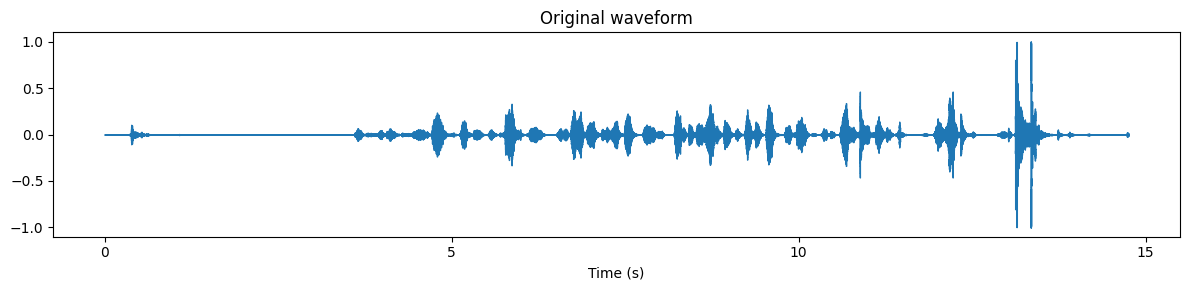

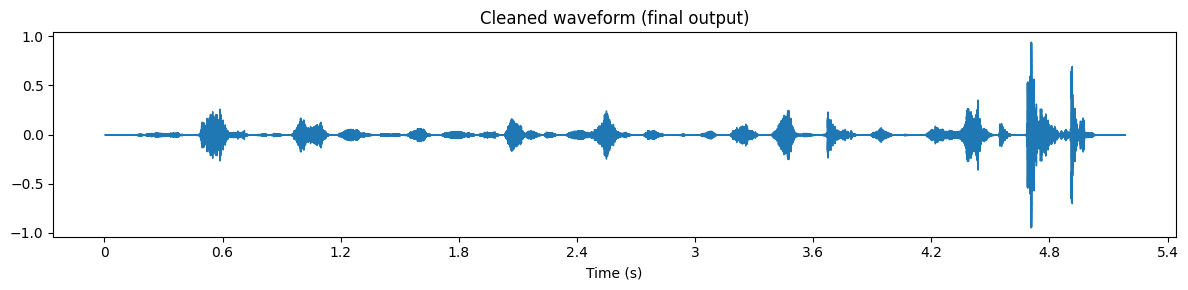

Play cleaned audio below:


In [10]:
# ## 6. Verification and Visualization (Code)
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio, display

# Plot original waveform (for a short preview to avoid huge plots)
plt.figure(figsize=(12, 3))
librosa.display.waveshow(y, sr=sr)
plt.title("Original waveform")
plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()

# Plot final cleaned waveform
# Load final file back to ensure dtype/sample rate correctness
clean_y, clean_sr = librosa.load(OUT_FILE, sr=None, mono=True)
plt.figure(figsize=(12, 3))
librosa.display.waveshow(clean_y, sr=clean_sr)
plt.title("Cleaned waveform (final output)")
plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()

# Show spectrograms optionally (comment/uncomment if desired)
def show_spectrogram(y_arr, sr_val, title="Spectrogram"):
    D = librosa.stft(y_arr, n_fft=1024)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    plt.figure(figsize=(12, 3))
    librosa.display.specshow(S_db, sr=sr_val, x_axis='time', y_axis='log')
    plt.colorbar(format="%+2.0f dB")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Uncomment to view spectrograms
# show_spectrogram(y, sr, title="Original Spectrogram")
# show_spectrogram(clean_y, clean_sr, title="Cleaned Spectrogram")

# Playback cleaned audio
print("Play cleaned audio below:")
display(Audio(OUT_FILE))
